In [1]:
# Imports
import dask.dataframe as dd 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# load data
train_data = dd.read_csv("/home/ifeenstra/Documents/Master_AI/Year_1/Data_Mining/vu-dmt-assigment-2-2023/training_set_VU_DM.csv")
test_data = dd.read_csv("/home/ifeenstra/Documents/Master_AI/Year_1/Data_Mining/vu-dmt-assigment-2-2023/test_set_VU_DM.csv")

In [2]:
display((train_data).head())


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [3]:
print(train_data.shape)
print(len(train_data))

(Delayed('int-7585d2b2-497a-487f-8574-ac42406bb627'), 54)
4958347


In [4]:
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
missing_value_df = pd.DataFrame({'column_name': train_data.columns,
                                 'percent_missing': percent_missing})

In [37]:
print(missing_value_df)

                    column_name  percent_missing
0                       srch_id         0.000000
1                     date_time         0.000000
2                       site_id         0.000000
3   visitor_location_country_id         0.000000
4       visitor_hist_starrating        94.920364
5          visitor_hist_adr_usd        94.897735
6               prop_country_id         0.000000
7                       prop_id         0.000000
8               prop_starrating         0.000000
9             prop_review_score         0.148517
10              prop_brand_bool         0.000000
11         prop_location_score1         0.000000
12         prop_location_score2        21.990151
13    prop_log_historical_price         0.000000
14                     position         0.000000
15                    price_usd         0.000000
16               promotion_flag         0.000000
17          srch_destination_id         0.000000
18          srch_length_of_stay         0.000000
19          srch_boo

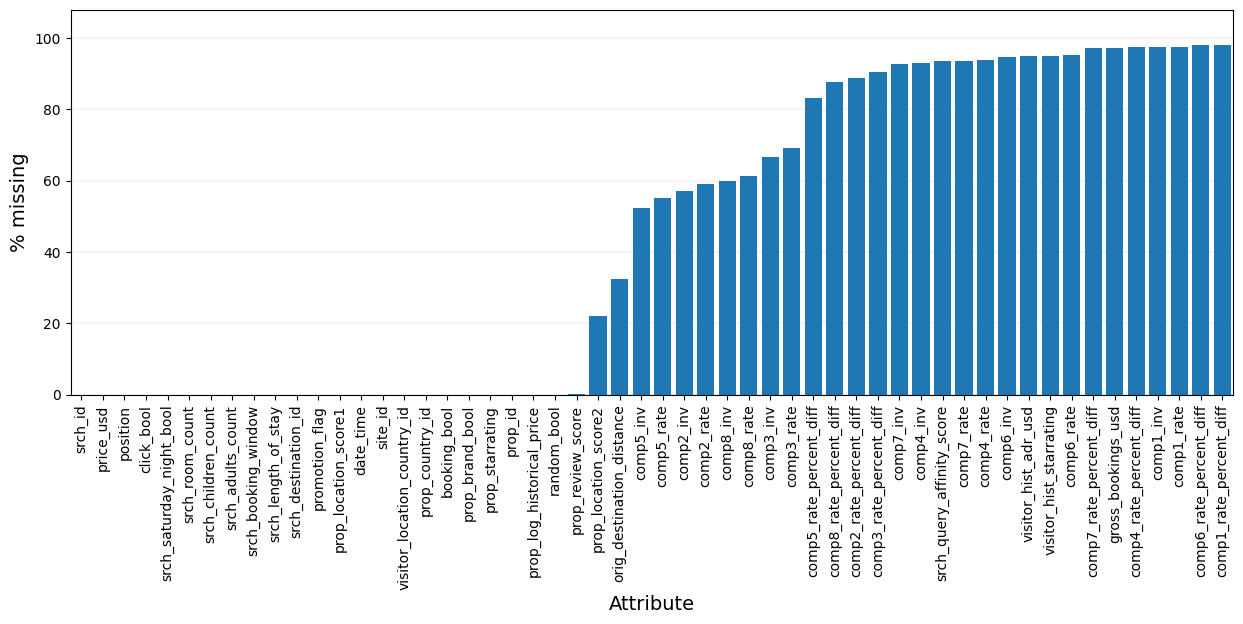

In [12]:
missing_value_df = missing_value_df.sort_values(by='percent_missing', ascending=True )

# Set up the plot
fig, ax = plt.subplots(figsize=(15,5))

# Create the bar plot
bar_width = 0.8 # Adjust this value to change the distance between bars
bars = ax.bar(missing_value_df['column_name'], missing_value_df['percent_missing'], width=bar_width)

# Set the x and y axis limits
ax.set_xlim(-0.5, len(missing_value_df['column_name']) - 0.5)
ax.set_ylim(0, max(missing_value_df['percent_missing']) * 1.1)  # Add some padding to the y-axis limit

# Customize plot
ax.set_xlabel('Attribute', fontsize=14)
ax.set_ylabel('% missing', fontsize=14)

# Rotate x-tick labels
plt.xticks(rotation=90)

#ax.grid(True)
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_axisbelow(True)


# Display the plot
plt.show()


In [39]:
outliers_variables = ['prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'comp1_rate', 'comp1_inv',
                                'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff',
                                'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
                                'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff']

In [40]:
def calculate_outliers(train_data, outliers_variables):
    pdf = train_data.compute()

    # Filter numeric columns
    numeric_columns = outliers_variables

    # Calculate quartiles and outliers for each numeric column
    stats = []
    for col in numeric_columns:
        q1 = train_data[col].quantile(0.25).compute()
        q2 = train_data[col].quantile(0.5).compute()
        q3 = train_data[col].quantile(0.75).compute()
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)][col].compute()
        stats.append({
            'column': col,
            'q1': q1,
            'q2': q2,
            'q3': q3,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': outliers
        })

    return stats 


In [41]:
# Function to normalize a Dask Series using min-max scaling
def normalize(df):
    normalized_df = df.copy()
    for col in df.select_dtypes(include=['number']).columns:
        min_val = df[col].min()
        max_val = df[col].max()
        normalized_df[col] = (df[col] - min_val) / (max_val - min_val)
    return normalized_df

In [42]:
normalized_df = normalize(train_data)

In [43]:
# Calculate the outliers for relevant variables
stats = calculate_outliers(train_data, outliers_variables)

: 

: 

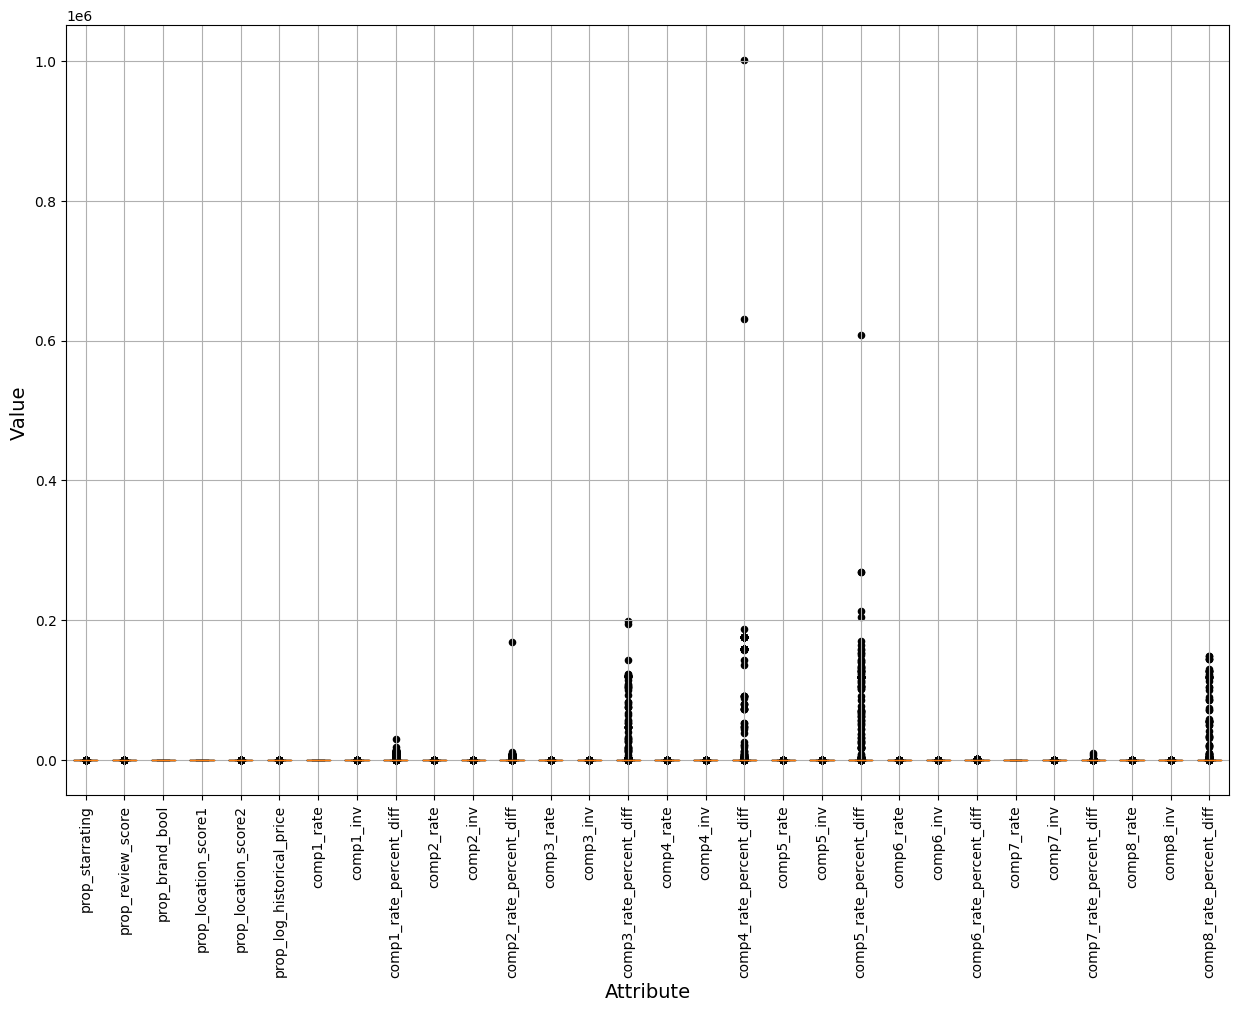

In [ ]:
# Function to format y-axis labels
def y_axis_formatter(x, pos):
    return f'{x / 1e7:.0f}e7'

# Create box plot
fig, ax = plt.subplots(figsize=(15, 10))

for i, s in enumerate(stats):
    ax.boxplot([s['q1'], s['q2'], s['q3']], positions=[i+1], widths=0.6)
    ax.scatter([i+1] * len(s['outliers']), s['outliers'], color='black', marker='o', s=20)

# Customize plot
ax.set_xticks(range(1, len(stats) + 1))
ax.set_xticklabels([s['column'] for s in stats])
ax.set_xlabel('Attribute',fontsize=14)
ax.set_ylabel('Value ', fontsize=14)

# Rotate x-tick labels
plt.xticks(rotation=90)
plt.grid()

# Set y-axis tick formatter
#ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Display the plot
plt.show()

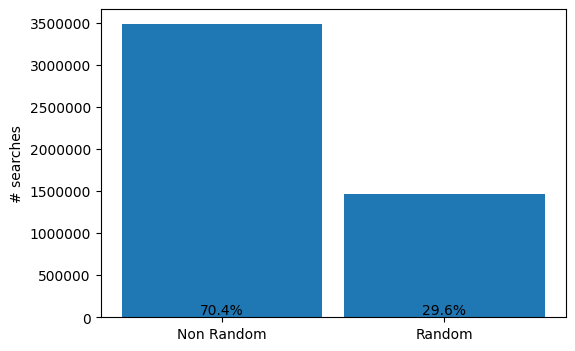

In [ ]:
# make random graph

# Compute frequency of binary values in the random bool column
value_counts = train_data['random_bool'].value_counts().compute()

# Create histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(value_counts.index, value_counts.values, width=0.9)

# Calculate percentage
total = value_counts.sum()
percentages = value_counts / total * 100

# Customize plot
binary_labels = {
    0: 'Non Random',
    1: 'Random'
}

# Customize plot
ax.set_xticks(value_counts.index)
ax.set_xticklabels([binary_labels[i] for i in value_counts.index])
ax.set_ylabel('# searches')

# Remove scientific notation from y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.0f}'))

#plt.grid()
# Add percentage in the middle of the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='bottom')


# Display the plot
plt.show()

# TODO make layout prettier

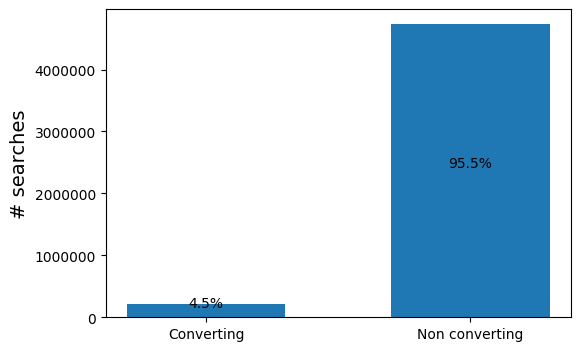

In [ ]:
# TODO make converting graph. if click is 1 or booking is 1 than count 

conversion_counts = len(train_data[(train_data['click_bool'] == 1) | (train_data['booking_bool'] == 1)].compute())
non_conversion_counts = len(train_data[(train_data['click_bool'] == 0) & (train_data['booking_bool'] == 0)].compute())

# Create a DataFrame to hold the counts
df_counts = pd.DataFrame({'Value': ['Converting', 'Non converting'], 'Count': [conversion_counts, non_conversion_counts]})

# Create a bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_counts['Value'], df_counts['Count'], width=0.6)

# Calculate percentage
total = conversion_counts + non_conversion_counts
percentages = [(conversion_counts / total * 100), (non_conversion_counts / total * 100)]

# Customize plot
ax.set_ylabel('# searches', fontsize=14)

# Remove scientific notation from y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.0f}'))

# Add percentage in the middle of the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='bottom')

# Display the plot
plt.show()

# check if click than book 
# 

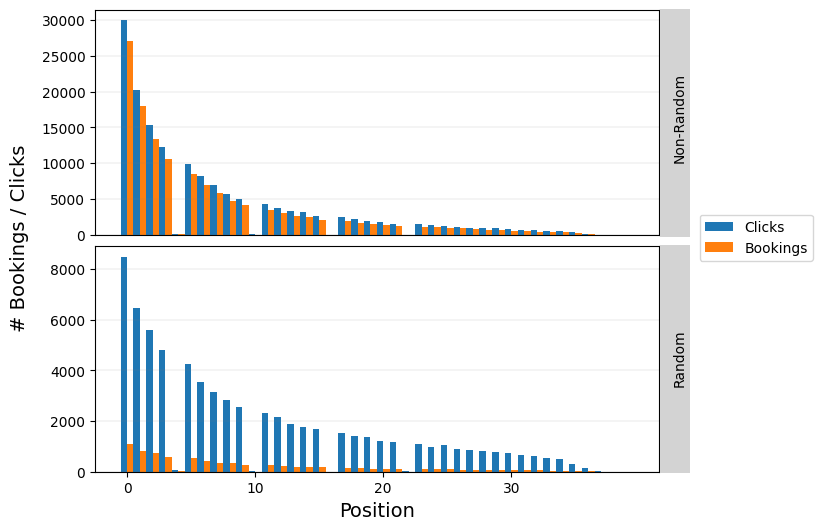

In [11]:
# TODO  make graph for position bias

# Compute the grouped data
grouped_random_false = train_data[train_data['random_bool'] == False].groupby('position').sum().compute()
grouped_random_true = train_data[train_data['random_bool'] == True].groupby('position').sum().compute()

# Create a figure with a specific gridspec
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[4, 1], height_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

# Create bar plots
width = 0.5  # Width of the bars
positions = np.arange(len(grouped_random_false.index))

# Subplot for 'random' == False
rects1 = ax1.bar(positions - width/2, grouped_random_false['click_bool'], width, label='Clicks')
rects2 = ax1.bar(positions + width/2, grouped_random_false['booking_bool'], width, label='Bookings')

#ax1.set_ylabel('Count')
ax1.set_xticks([])
#ax1.set_xticks(np.arange(0, max(grouped_random_false.index), 10))
#ax1.grid(True, which='both', color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax1.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Subplot for 'random' == True
rects3 = ax2.bar(positions - width/2, grouped_random_true['click_bool'], width, label='Clicks')
rects4 = ax2.bar(positions + width/2, grouped_random_true['booking_bool'], width, label='Bookings')

ax2.set_xlabel('Position', fontsize=14)
#ax2.set_ylabel('# Bookings / Clicks')
ax2.set_xticks(positions)
ax2.set_xticks(np.arange(0, max(grouped_random_true.index), 10))
#ax2.grid(True, which='both', color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Create the legend
fig.legend(['Clicks', 'Bookings'], loc='center right', bbox_to_anchor=(0.85, 0.5))
fig.text(0.04, 0.5, '# Bookings / Clicks', va='center', rotation='vertical', fontsize=14)

# # Add text labels for Random and Non-Random
# fig.text(0.95, 0.75, 'Non-Random', ha='center', va='center', rotation='vertical')
# fig.text(0.95, 0.25, 'Random', ha='center', va='center', rotation='vertical')

# Add text labels for Random and Non-Random with rectangle patches
rectangle1 = patches.Rectangle((0.69, 0.5005), 0.03, 0.38, transform=fig.transFigure, clip_on=False, edgecolor="none", facecolor="lightgrey")
rectangle2 = patches.Rectangle((0.69, 0.108), 0.03, 0.38, transform=fig.transFigure, clip_on=False, edgecolor="none", facecolor="lightgrey")

fig.add_artist(rectangle1)
fig.add_artist(rectangle2)

fig.text(0.71, 0.7, 'Non-Random', ha='center', va='center', rotation='vertical')
fig.text(0.71, 0.3, 'Random', ha='center', va='center', rotation='vertical')

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.05)

# Confusion matrices

Variables are group in 5 categories:

- Search criteria: date_time, srch_destination_id, srch_length_of_stay, srch_booking_window, srch_adults_count, srch_children_count, srch_room_count, srch_saturday_night_bool
- Hotel characteristics (static): prop_id, prop_country_id, prop_starrating, prop_review_score, prop_brand_bool, prop_location_score1, prop_location_score2, prop_log_historical_price 
- Hotel characteristics (dynamic): position, price_usd, promotion_flag, click_bool, booking_bool, gross_bookings_usd, srch_query_affinity_score 
- Visitor information: visitor_location_country_id, orig_destination_distance, visitor_hist_starrating, visitor_hist_adr_usd  
- Competitive OTA information: comp_rate, comp_inv, comp_rate_percent_diff (fill in number between 1-8)

In [15]:
# make heatmap, negative correlations
import seaborn as sns

# Search criteria confusion matrix
def heatmap(columns):

    # Convert Dask DataFrame to Pandas DataFrame
    df = train_data[columns].compute()

    # Compute correlation matrix
    corr_matrix = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()





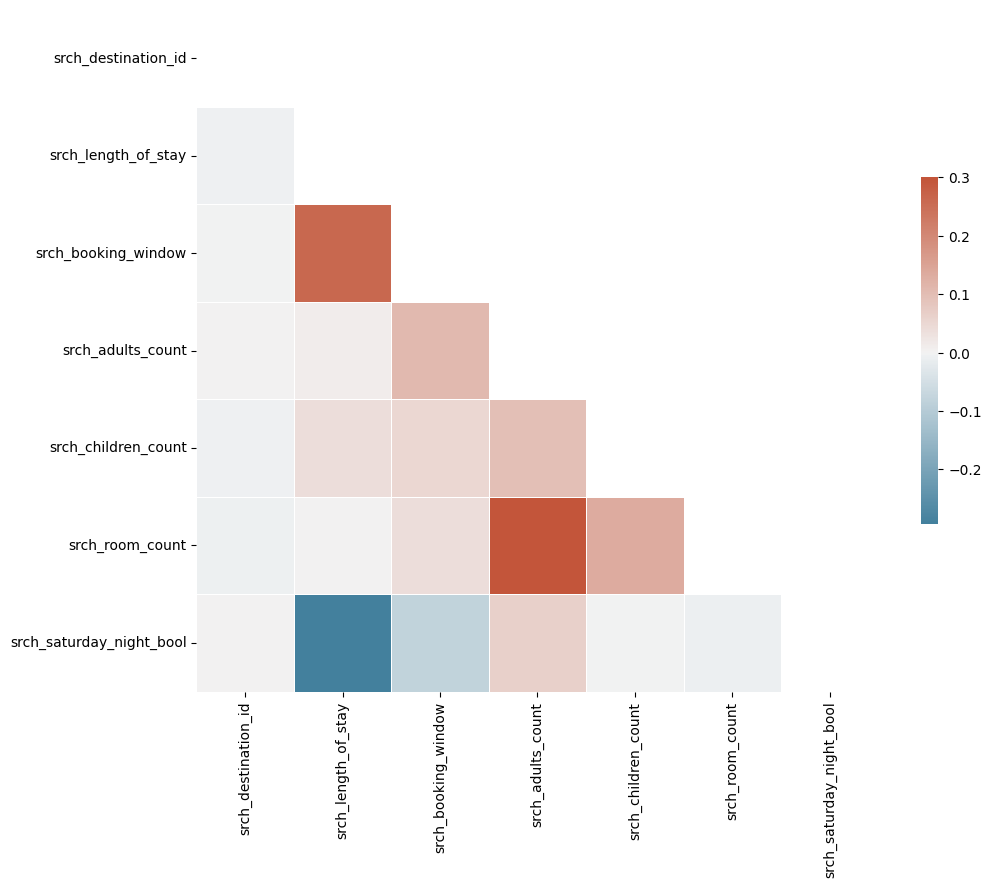

In [17]:
# Search criteria columns
search_criteria = ['date_time', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']
heatmap(search_criteria)

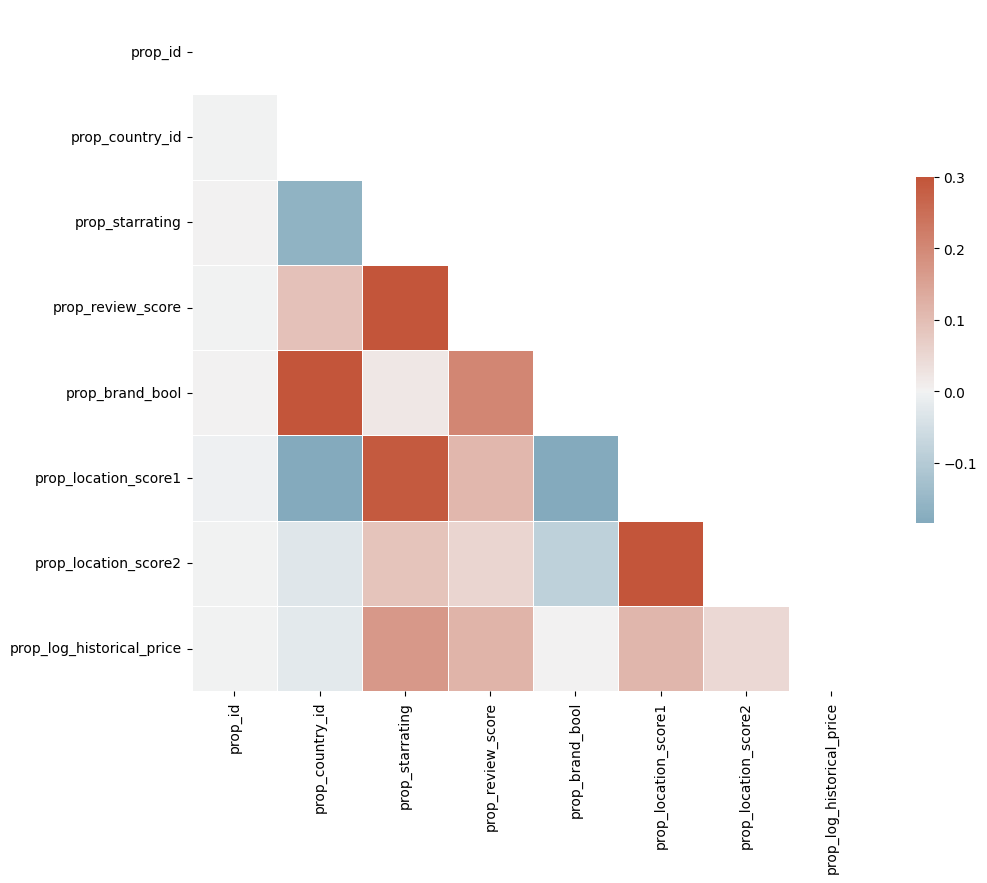

In [19]:
#Hotel characteristics (static)
hotel_static = ['prop_id', 'prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price'] 
heatmap(hotel_static)

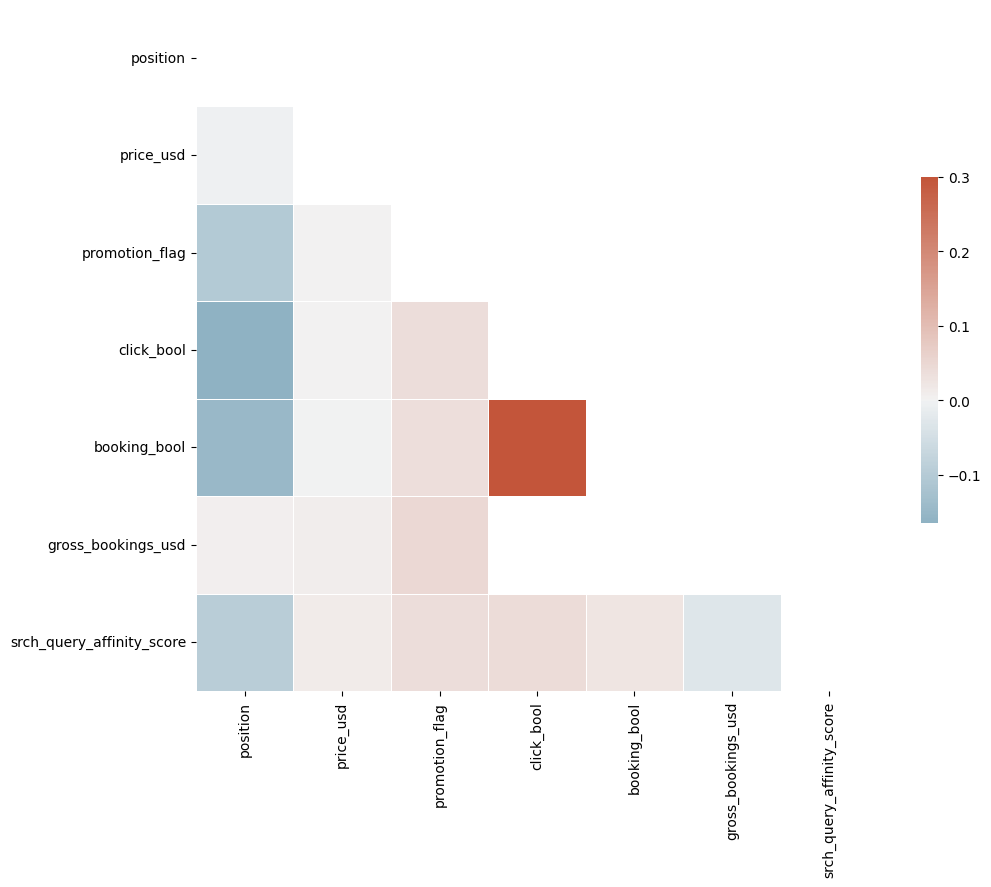

In [21]:
#Hotel characteristics (dynamic)
hotel_dynamic = ['position', 'price_usd', 'promotion_flag', 'click_bool', 'booking_bool', 'gross_bookings_usd', 'srch_query_affinity_score']
heatmap(hotel_dynamic) 

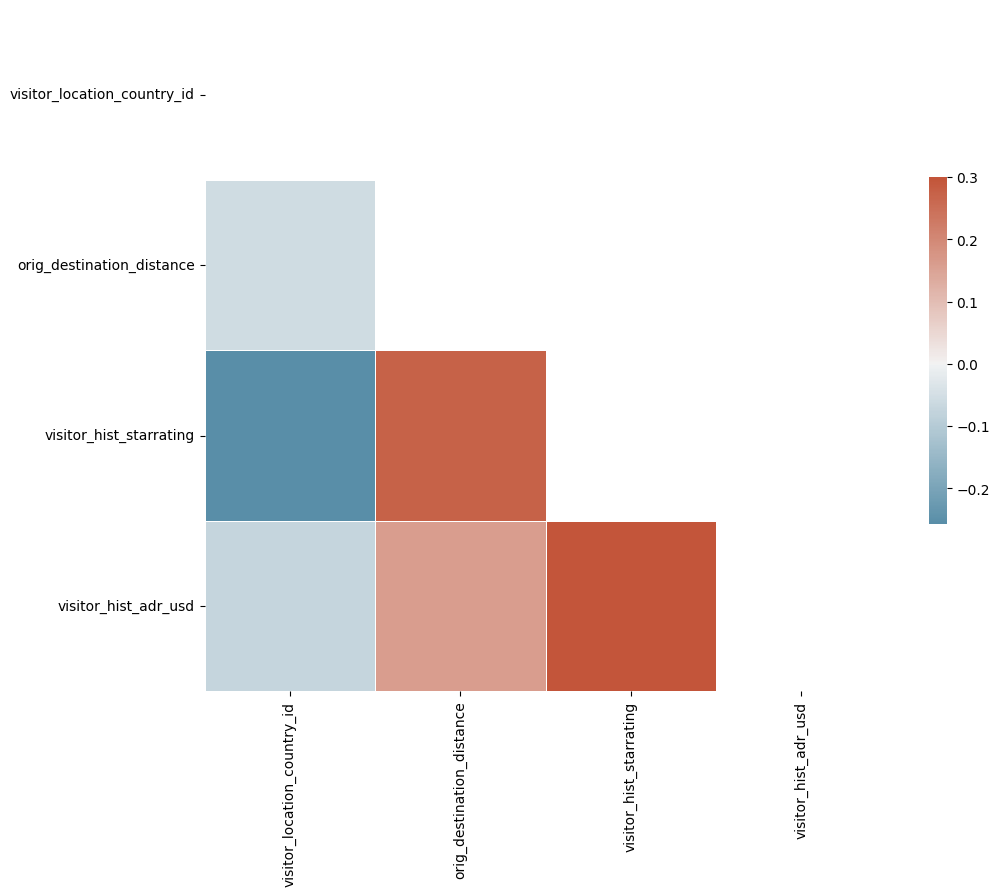

In [22]:
# Visitor information
visitor_info = ['visitor_location_country_id', 'orig_destination_distance', 'visitor_hist_starrating', 'visitor_hist_adr_usd']
heatmap(visitor_info)